# Stochastic methods- MCMC assignment
-----------------

## import

In [1]:
import pandas as pd
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import minimize
import math
from scipy.stats import multivariate_normal
from scipy.stats import norm
import random
from scipy.stats import gaussian_kde

## Part A- Modeling

<b> 1. Read the data and prepare it to the process

In [2]:
# read the data from the excel file (without put the first row in the data again)
data_new_cases = pd.read_excel('covid19_daily_new_cases.xlsx', skiprows=[0])
# change the name of the columns to be in another language (ENG)
data_new_cases = data_new_cases.rename(columns = {'תאריך': 'daily_date', 'מספר מאומתים חדשים': 'daily_num_new_cases', 'ממוצע נע 7': 'rolling_avg_7', 'מאומתים מצטבר': 'cummulative_num_cases'})
data_new_cases

,daily_date,daily_num_new_cases,rolling_avg_7,cummulative_num_cases
0,12-02-2020,0,7,7
1,13-02-2020,0,3,7
2,14-02-2020,0,2,7
3,15-02-2020,0,1,7
4,16-02-2020,0,1,7
...,...,...,...,...
472,29-05-2021,12,19,839457
473,30-05-2021,3,19,839460
474,31-05-2021,15,16,839475
475,01-06-2021,35,14,839510


In [3]:
# show the types of the data's columns
data_new_cases.dtypes

daily_date               object
daily_num_new_cases       int64
rolling_avg_7             int64
cummulative_num_cases     int64
dtype: object

we can see that the daily_date coulmn is string and not datetime object- so we need to convert it

In [4]:
data_new_cases['daily_date']= pd.to_datetime(data_new_cases['daily_date'], format='%d-%m-%Y')

add 2 new columns to the dataframe for the prediction

In [5]:
# add the day of the week according the date (0=monday)
data_new_cases['day'] = data_new_cases['daily_date'].dt.dayofweek

In [6]:
# add the number of cases before a week- will give another perspective on the same day in the previous week
data_new_cases['num_cases_before_week'] = None
# only if the index is not lower than 7, save the number of cases and update the correct cell in the dataframe
for location in range(len(data_new_cases['daily_num_new_cases'])):
    if location-7 >=0:
        num_cases = data_new_cases.iloc[location-7]['daily_num_new_cases']
        data_new_cases.at[location, 'num_cases_before_week']  = int(num_cases)
data_new_cases['num_cases_before_week'] = pd.to_numeric(data_new_cases['num_cases_before_week'])

Now, need to get the data with the dates that I got. The dates are 16-01-21 until 17-03-21. so I need to cut the data with these dates only

In [7]:
# define the start and end dates
start_date = '2021-01-16'
end_date = '2021-03-17'
# get only the data with dates betweem the start and end dates
data_new_cases_by_dates = data_new_cases.loc[(data_new_cases['daily_date'] >= start_date) & (data_new_cases['daily_date'] < end_date)]
data_new_cases_by_dates

,daily_date,daily_num_new_cases,rolling_avg_7,cummulative_num_cases,day,num_cases_before_week
339,2021-01-16,5087,8328,545215,5,5158.0
340,2021-01-17,5648,8318,550863,6,6937.0
341,2021-01-18,10117,8134,560980,0,9713.0
342,2021-01-19,8624,8192,569604,1,9298.0
343,2021-01-20,8364,8095,577968,2,9471.0
344,2021-01-21,7273,7937,585241,3,9295.0
345,2021-01-22,7388,7648,592629,4,8429.0
346,2021-01-23,2449,7500,595078,5,5087.0
347,2021-01-24,4945,7123,600023,6,5648.0
348,2021-01-25,8731,7022,608754,0,10117.0


In order to examine what the data looks like only on the selected date range, we will convert the data frame to have an index by date and the new cases column. This is also done for the index by date and column of cases according to a 7-day moving window, and finally a cumulative distribution graph is made for a cumulative number of cases.

In [8]:
# get only cases by daily number of new cases and by rolling average by 7 days and set the index by the date
data_case_dates = data_new_cases_by_dates[['daily_date','daily_num_new_cases' ,'rolling_avg_7']].set_index('daily_date', drop=True)
data_case_dates.head()

,daily_num_new_cases,rolling_avg_7
daily_date,,
2021-01-16,5087,8328
2021-01-17,5648,8318
2021-01-18,10117,8134
2021-01-19,8624,8192
2021-01-20,8364,8095


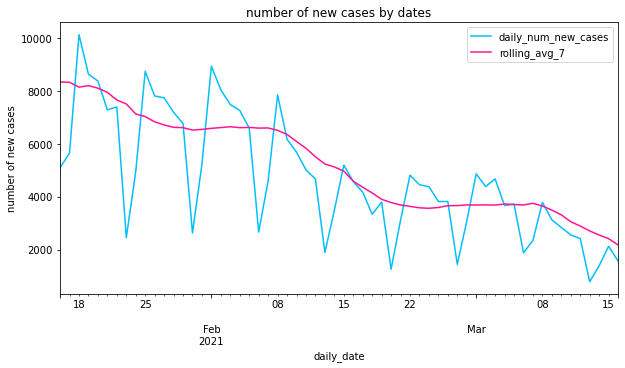

In [9]:
ax = data_case_dates.plot(figsize=(10,5), color=['deepskyblue','deeppink'])
ax.set_ylabel('number of new cases')
ax.set_title('number of new cases by dates')
plt.show()

In [10]:
# get commulative number of new daily cases and set the index by the date
data_comm_case_dates = data_new_cases_by_dates[['daily_date','cummulative_num_cases']].set_index('daily_date', drop=True)
data_comm_case_dates.head()

,cummulative_num_cases
daily_date,
2021-01-16,545215
2021-01-17,550863
2021-01-18,560980
2021-01-19,569604
2021-01-20,577968


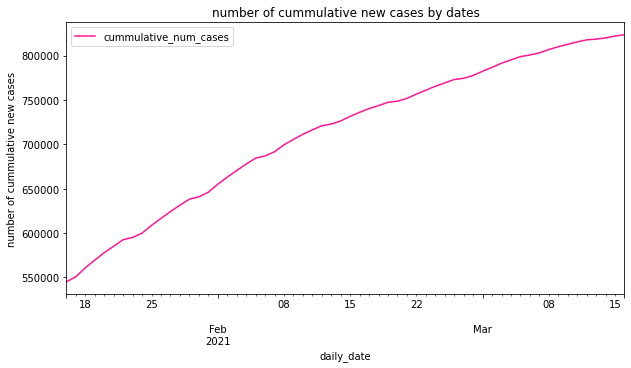

In [11]:
ax = data_comm_case_dates.plot(figsize=(10,5), color=['deeppink'])
ax.set_ylabel('number of cummulative new cases')
ax.set_title('number of cummulative new cases by dates')
plt.show()

<b> 2. modeling: </b> <br>
As can be seen in the graph the number of new cases according to a moving window of 7 days, there is a decline trend reminiscent of a linear decline. I will therefore choose to use the linear regression model for the MCMC model. However it seems that the decline is done with ups and downs so that over time the increase is smaller. In order to also address the ups and downs in the, I take into account both the time stamp, the number of cases that occurred a week ago and the day of the week- so the model will be multivariate linear regressions. Today of the week is important as well as we know that on the weekends there is a decline that behaves similarly due to a small number of tests. <br>
The model will be: 𝜇_t = a_0 + a_1 * t + a_2 * cases_in_last_week + a_3 * day_num. Where 𝜇_𝑡 is the daily number of cases at time t and a_0, a_1, a_2 and a_3 are the unknown model parameters. <br>
For time points we have dates for each day in the given time window. In order for the model to work with units of measure describing a unit of time per day, we will add to the data a column t containing the range of days 1-60 separately.

In [12]:
# get the range of number of days (60 days)
num_of_days = data_new_cases_by_dates.shape[0]
range_days = np.arange(1,num_of_days+1)
# add new column for the time with all this numbers
data_new_cases_by_dates.insert(0, 't', list(range_days))
data_new_cases_by_dates.head()

,t,daily_date,daily_num_new_cases,rolling_avg_7,cummulative_num_cases,day,num_cases_before_week
339,1,2021-01-16,5087,8328,545215,5,5158.0
340,2,2021-01-17,5648,8318,550863,6,6937.0
341,3,2021-01-18,10117,8134,560980,0,9713.0
342,4,2021-01-19,8624,8192,569604,1,9298.0
343,5,2021-01-20,8364,8095,577968,2,9471.0


A function of the model is constructed which receives the parameters a_0, a_1, a_2, a_3 and returns for all the data the predicted values according to the multivariate linear regression model.

In [13]:
def the_model(a_0, a_1, a_2 ,a_3, data):
    # save range for the number of perieds (days)
    num_of_days = data.shape[0]
    range_days = np.arange(1,num_of_days+1)
    # initial data frame that will hold the predicted data for each time step (period)
    predicted_data = pd.DataFrame(range_days, columns=['t'])
    # add initial columns for the predicted values
    predicted_data['predict'] = None
    # go all over the data
    for i, row in data.iterrows():
        # save the time (period) and the number of cummulative cases
        time = row['t']
        day = row['day']
        last_cases = row['num_cases_before_week']
        # caculate the predict value with the parameters
        mu_t = a_0 + a_1*time + a_2*last_cases + a_3*day
        # if the predicted values is negative so cahnge to 0 because the numer of new cases is non-negative
        if mu_t < 0:
            mu_t = 0
        # put the predicted data in the correct location in the column 'predict'
        predicted_data.loc[predicted_data['t'] == time, 'predict'] = mu_t
    return predicted_data

<b> 3. Y_t- number of cases at time t: </b> <br> 
Now, we need to decide on the distribution of this variable. This variable is the number of new cases each day. We will examine how it is distributed by creating a histogram and from there we will decide on the desired distribution.

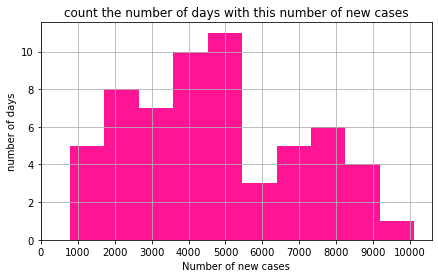

In [14]:
# create histogram for the number of new cases (for a day)
plt.figure(figsize=(7,4))
plt.hist(data_new_cases_by_dates['daily_num_new_cases'], color = 'deeppink')
# x-axis label
plt.xlabel('Number of new cases')
# frequency label
plt.ylabel('number of days')
# plot title
plt.title('count the number of days with this number of new cases')
plt.xticks(range(0,10001,1000))
plt.grid()
plt.show()

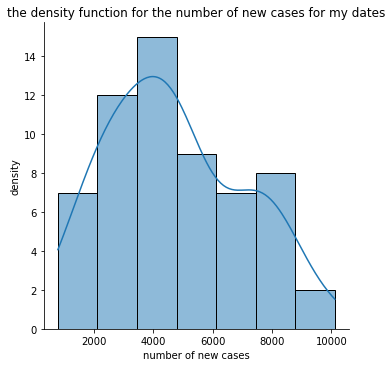

In [15]:
# the density function for the number of new cases
# get series of the column and reset index
dataserie = data_new_cases_by_dates['daily_num_new_cases']
dataserie.reset_index(drop=True, inplace=True)
# plot the density
sns.displot(dataserie, kde= True)
# add labels
plt.xlabel('number of new cases')
plt.ylabel('density')
plt.title('the density function for the number of new cases for my dates')
plt.show()

From the presentation of the histogram and the distribution created from it, it can be seen that this distribution is reminiscent of a normal distributio. Apparently the distribution was indeed taken from a normal distribution but looking only at my date range there are different truncations. In this distribution there is a parameter for expectancy, std (as in a normal normal distribution) <br>
Therefore we will say that Y_t ~ N(mu=mu_t, sigma^2)

<b> 4. calibrate model parameters: </b> <br>
Now, neede to using maximum likelihood estimation on the data. We want to reduce the error so that the error is the difference in the square between the data and the model and hence that the MSE will constitute for us the Likelihood function.

In [16]:
# this function get the data frame with the actucal data and parameters of the model and return the SSE value
def MSE(param, data):
    # get the predicted values for each row in the data with the parameters from the input
    data_prediction = the_model(param[0],param[1],param[2], param[3], data)
    # join the data with the actual values with the data with the predicted values
    data_with_pred = data_for_model.merge(data_prediction)
    # caculate the sse for each row
    data_with_pred['error'] = (data_with_pred['predict']-data_with_pred['daily_num_new_cases'])**2
    # get the sum of SSE for all the data
    sse = data_with_pred.sum()['error']
    return sse

for the model we need to use in the t which means the timestamp, the day and the number of cases before 7 day axactly. In addition we will use in the number of daily cases.

In [17]:
data_for_model = data_new_cases_by_dates[['t','daily_num_new_cases','day', 'num_cases_before_week']]
data_for_model.describe()

,t,daily_num_new_cases,day,num_cases_before_week
count,60.000000,60.000000,60.000000,60.000000
mean,30.500000,4723.750000,3.000000,5467.866667
std,17.464249,2289.850159,2.058467,2354.806915
min,1.000000,783.000000,0.000000,1255.000000
25%,15.750000,3010.750000,1.000000,3766.750000
50%,30.500000,4508.000000,3.000000,4977.000000
75%,45.250000,6628.000000,5.000000,7409.500000
max,60.000000,10117.000000,6.000000,10117.000000


My initial guess will be based on statistics from above. <br>
- thete1 is the intersection and will be the mean of new daily cases. <br>
- theta2 is multiply the time and we except to decline accordint to the plots so will be minus the mean of time. <br>
- theta3 is muiltiply by the number of cases before a week ago, and we want a decline but smaller so it will be 0.9 but minus. <br>
- theta4 is multiply by the number of day (0-6) so it will be smaller and minus for the decline. smaller because we want to preserve the number of cases in the same day. <br>


In [18]:
theta_initial_guess = list(np.array([4000,-30,-0.5,-0.9]))

For the best-fit parameters I will use in minimize that get the function we want to minimize, the initial guess and parameters for the function if needed. Then I take the best paramaters.

In [19]:
result = minimize(MSE, theta_initial_guess, args=(data_for_model), method="Powell")
theta1, theta2, theta3, theta4 = result.x[0] ,result.x[1] ,result.x[2], result.x[3]
print ('the best fit parameters\n for theta1 is', theta1, '\nfor theta2 is', theta2 , '\nfor theta3 is', theta3, '\nand for theta4 is', theta4)
print ('the target function is', result.fun)

the best fit parameters
 for theta1 is 2289.657579619677 
for theta2 is -30.70310499575056 
for theta3 is 0.6897993657832082 
and for theta4 is -120.694885197177
the target function is 32270066.64698071


<b> 5. plots: </b> <br> 
on the same plot we have the model fit and the actucal data. these will be done for the number of new daily cases. As can be seen in the plot the prediction is smaller as the time pass as I wanted. In addition we can see the trend of the decline that occuured sometimes- I guuess that it is the tests in the weekend do there are small number of tests compared to the rest of the week. So, I think that the chosen model is good.

the number of new daily cases against predict data

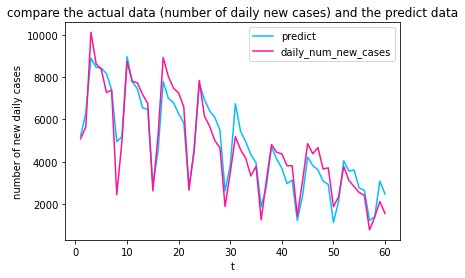

In [20]:
# apply the model with the best parameters to get the predicted data
pred_data = the_model(theta1, theta2, theta3,theta4, data_for_model)
# add to the predicted data the actual data
compare_pred_actual = pred_data.merge(data_for_model[['t','daily_num_new_cases']]).set_index('t')
# plot them on the same plot
compare_pred_actual.plot(color=['deepskyblue','deeppink'])
plt.title('compare the actual data (number of daily new cases) and the predict data')
plt.ylabel('number of new daily cases')
plt.show()

-----------------------
## Part B- MCMC

In [21]:
# the best parameters I got
thetas_best_fit = np.array([theta1, theta2, theta3, theta4])

<b> 6. functions for MCMC and apply it: </b> <br>
B.7 is calculate here but we can see the results on the plots in B.9

Functions for MCMC

In [22]:
# the function get the thetas, the data and the std value and return the final likelihood
def loglikelihood(theta_initial, data, std):
    # get the actual data
    actual_y = data['daily_num_new_cases']
    # the number of records for the equation of log likelihood of normal distribution
    n = actual_y.shape[0]
    # get the sse for the likelihood
    sse = MSE(theta_initial, data)
    # caculate the likelihood
    likelihood = -(n/2)*np.log(2*np.pi)-(n/2)*np.log(std**2)-(1/(2*(std**2)))*sse
    return likelihood

In [23]:
# the function get thethas as x, mu and sigma (covariance matrix) from the multivariate normal distibution and return the pdf
def calc_pdf_multi_normal(x, mu, sigma):
    # number of parameters
    k = len(x)
    # calc the pdf by the correct formula
    pdf = ((2*np.pi)**(-(k/2))) * ((np.linalg.det(sigma))**0.5) * (np.exp(-0.5*(x-mu).T.dot(np.linalg.inv(sigma).dot(x-mu))))
    return pdf

The MCMC algorithm

In [24]:
# the function apply the mcmc algorithm by Metropolis-Hasting algorithm.
# the function get all the parameters I need: the initial thetas, the number of iteration, the initial scaling factor
# the data for the model, the mu of thetas and covariance and the number of total iteration for the warm period.
# the function return df of all the tethas with the acceptaness measure, list of all the acceptance rates per iteration
# and list for all the curernt thetas per iteration.
def MCMC_alg(thetas, number_of_iteration, scaling_factor, data_for_model, mean_thetas, cov_theta_prior, cov_j, total_iteration_warm):
    # define the current thetas with the initial thetas
    current_thetas = thetas
    
    # initialize a df with all the data about the thetas: all the values of thetas and True if accept and False otherwise
    thetas_list = list(current_thetas)
    thetas_list.append(True)
    dic_thetas = {'theta1': [thetas_list[0]], 'theta2': [thetas_list[1]],
                  'theta3': [thetas_list[2]], 'theta4': [thetas_list[3]], 'accept': [thetas_list[4]]}
    df_thetas = pd.DataFrame(dic_thetas)
    
    # initialize the number of acceptancess to be zero and an empty list for the acceptance rates per iteration
    number_of_acceptancess = 0
    acceptance_rate_per_iteration = []
    # initiliaze the k for the updating after 500 iterations
    k = 0
    # initialize a list which hold all the current thetas in each iteration
    thetas_current_per_iteration = []
    
    # for each iteration
    for iter_ in range(1,number_of_iteration+1):
        # update the list for all the current thetas
        thetas_current_per_iteration.append(current_thetas)
        # get proposed thetas feom multivariate normal distribution from the formula
        thetas_propose = np.random.multivariate_normal(current_thetas, (scaling_factor**2)*cov_j)
        # calculate the log likelihood for the current thetas and for the proposed
        log_liklihood_thetas = loglikelihood(current_thetas, data_for_model, 500)
        log_likelihood_thetas_propose = loglikelihood(thetas_propose, data_for_model, 500)
        # calculate the prior for the current and proposed thetas
        prior_thetas = calc_pdf_multi_normal(current_thetas, mean_thetas, cov_theta_prior)
        prior_thetas_propose = calc_pdf_multi_normal(thetas_propose, mean_thetas, cov_theta_prior)
        # calculate the ratio for the r
        check_ratio = (log_likelihood_thetas_propose*prior_thetas_propose)/(log_liklihood_thetas*prior_thetas)
        # get the minimu value
        r = min(check_ratio, 1)
        # get a number from uniform distibution (U(0,1))
        alpha = np.random.uniform()
        
        # get a list for the proposed thetas so I will append it to the df later
        thetas_propose_list = list(thetas_propose)
        df_length = len(df_thetas)
        
        # if alpha smaller than r so accept the proposed thetas and increase the number of acceptancess
        if alpha < r:
            current_thetas = thetas_propose
            number_of_acceptancess += 1
            # add True because accept the thetas and append new row to the df
            thetas_propose_list.append(True)
            df_thetas.loc[df_length] = thetas_propose_list
        # if alpha is not smaller than r 
        else:
            # add False because accept the thetas and append new row to the df
            thetas_propose_list.append(False)
            df_thetas.loc[df_length] = thetas_propose_list
        
        # caculate the acceptance rate for this iteration and append it to the list
        acceptance_rate = number_of_acceptancess / iter_
        acceptance_rate_per_iteration.append(acceptance_rate)

        # warm period- if the itertion is 500,1000,1500,... and the numbr of this iteratin is smaller than the number of iteration for the warm period
        if ((iter_%500) == 0) & (iter_ <= total_iteration_warm):
            # update the k
            k += 1
            # get the df only for the last 500 iterations
            df_last_500 = df_thetas.loc[iter_-500:,:]
            # get the acceptance rate and the covariance matrix (proposed one) only for the last 500 iterations
            acceptance_rate_500 = sum(df_last_500['accept'])/len(df_last_500)
            proposed_covariance = np.cov(df_last_500[['theta1', 'theta2', 'theta3', 'theta4']].values,rowvar = False) 
            # update the covariance of J and the scaling factor
            cov_j = 0.25*cov_j + 0.75*proposed_covariance
            scaling_factor = scaling_factor * np.exp((acceptance_rate_500-0.23)/k)
            
    return df_thetas, acceptance_rate_per_iteration, thetas_current_per_iteration

Define parameters for the MCMC algorithm

In [25]:
# define the covariane of thetas which have normal distibution with mu=best fit parameter I got and std is the sqrt of this value
cov_theta_prior = np.diag((abs(thetas_best_fit))**0.5)
# the mu (exception) for the prior distribution of thetas
mean_thetas = thetas_best_fit
# define the covariance fot the J distribution
cov_j = np.diag(np.array([0.005, 0.005, 0.005, 0.005]))
# define the number of iterations
number_of_iteration = 15000
# define the initial scaling factor
initial_scaling_factor = 2.4/len(thetas_best_fit)
# define the number of iteratin for the warm period
total_iteration_warm = 5000

Run the MCMC algorithm on 3 differents initial thetas

In [26]:
# define a seed to get the same result
np.random.seed(42)
# initialize lists: 1) for the df with all the data on thetas 2) for all the acceptance rates. here I save the result for the 3 differents thetas
df_3_different_thetas = []
acceptance_rate_3_different_thetas = []
# initialize 3 diffrents sets of thetas by sample them from multivariate normal distribution
for i in range(3):
    thetas = np.random.multivariate_normal(mean_thetas, cov_theta_prior)
    print ('the initial guess of thetas for iteration '+str(i+1)+' is:', thetas)
    # apply the mcmc on each of the initial thetas
    df_thetas, acceptance_rate_per_iteration, thetas_current_per_iteration = MCMC_alg(thetas, number_of_iteration, initial_scaling_factor, data_for_model, mean_thetas, cov_theta_prior, cov_j, total_iteration_warm)
    # append the results to the lists
    df_3_different_thetas.append(df_thetas)
    acceptance_rate_3_different_thetas.append(acceptance_rate_per_iteration)

the initial guess of thetas for iteration 1 is: [ 2.29309355e+03 -2.91784844e+01  2.07779824e+00 -1.21153167e+02]
the initial guess of thetas for iteration 2 is: [ 2.28765262e+03 -3.34717318e+01  1.84849139e+00 -1.19688488e+02]
the initial guess of thetas for iteration 3 is: [ 2.28077230e+03 -3.32722957e+01  1.53335929e+00 -1.24872662e+02]


<b> 8. Gelman-Rubin test

create the function for gelman rubin test

In [27]:
# the function apply the Gelman-Rubin test. it get the dataframes without the warn period for all the chains, the name of 
# thetas parameter, the n- number of records in the df and the number of chains.
# the function prints all the values for each theta (by the test)
def gelman_rubin_test(all_thetas_df_cut_warm, thetas_names, n, num_chain):
    # initialize empty lists for the variance and means for each theta for each chain
    vars_by_chains = []
    means_by_chain = []
    
    # for each chain
    for j in range(num_chain):
        # initialize the variance and mean lists for each theta
        var_for_chain = []
        mean_for_chain = []
        # for each theta
        for num in range(len(thetas_names)):
            # save the theta name
            theta_name = thetas_names[num]
            # calculate the variance for this theta and appent it to the list
            var_theta = all_thetas_df_cut_warm[j][theta_name].var()
            var_for_chain.append(var_theta)
            # calculate the mean for this theta and appent it to the list
            mean_theta = all_thetas_df_cut_warm[j][theta_name].mean()
            mean_for_chain.append(mean_theta)
        # add the mean and variance for this chain for all the thetas to the lists for all the chains
        means_by_chain.append(mean_for_chain)
        vars_by_chains.append(var_for_chain)
    # save a list of the means for each theta by all the chains
    mean_of_means_for_chain = list(pd.DataFrame(means_by_chain).mean())
    # calculate the W for this test
    W = np.array(pd.DataFrame(vars_by_chains).mean())
    # convert the means for each theta by chain to numpy array for calculate the B
    means_by_chain = [np.array(j) for j in means_by_chain]
    # calculate the B for this test
    B = (n/(num_chain-1)) * np.sum(((means_by_chain-np.array(mean_of_means_for_chain))**2), axis=0)
    # calculate var(theta)
    var_theta = (1-(1/n))*W + (1/n)*B
    # calculate R
    R = np.sqrt(var_theta/W)
    # print all the results
    for i in range(len(R)):
        print ('for '+thetas_names[i]+' the result from this test is: ', R[i])

define the parameters for the function and apply it:

In [28]:
# initialize a list for all the df with the thetas but without the warm period
all_thetas_df_cut_warm = []
# create a list with the names of the thetas
thetas_names = ['theta1', 'theta2', 'theta3', 'theta4']
# for each df we get from the 3 runs
for i in range(len(df_3_different_thetas)):
    # remove the warm period and append it to the list
    all_thetas_df_cut_warm.append(df_3_different_thetas[i].loc[total_iteration_warm:,:])
# define the number of records for the test
n = len(all_thetas_df_cut_warm[0])
# define the number of chains for the test
num_chain = len(all_thetas_df_cut_warm)

# apply the test
gelman_rubin_test(all_thetas_df_cut_warm, thetas_names, n, num_chain)

for theta1 the result from this test is:  1.0020249751600747
for theta2 the result from this test is:  1.0014316730651138
for theta3 the result from this test is:  1.0002971030623358
for theta4 the result from this test is:  1.00014533272461


<b> 9. plots </b> <br>
B.7 is also here, we can saw it in the plots

9.1: acceptance rate per iteration

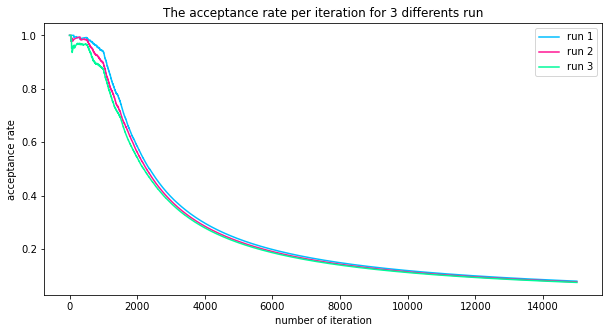

In [29]:
# create a df for the acceptance rate for each running 
acceptance_rate_df = pd.DataFrame(acceptance_rate_3_different_thetas, index=['run 1', 'run 2', 'run 3']).T
# plot the df (3 lines for 3 columns)
acceptance_rate_df.plot(figsize=(10,5), color=['deepskyblue','deeppink', 'mediumspringgreen'])
# add titles
plt.title('The acceptance rate per iteration for 3 differents run')
plt.ylabel('acceptance rate')
plt.xlabel('number of iteration')
plt.show()

9.2: trace plot of 3 iteration for each parameter

In [30]:
# the function plot the trace of theta for each iteration
def trace_plot(df_3_run, name_theta):
    # define 3 different colors
    colors = ['deepskyblue','deeppink', 'mediumspringgreen']
    # for each running
    for i  in range(len(df_3_run)):
        # plot the trace for the theta
        df_3_run[i][name_theta].plot(figsize=(10,5), color = [colors[i]], label='run '+str(i+1))
    # add titles
    plt.title('The trace for 3 iteration for '+name_theta)
    plt.ylabel('proposed '+  name_theta +' value')
    plt.xlabel('number of iteration')
    plt.legend()
    plt.show()

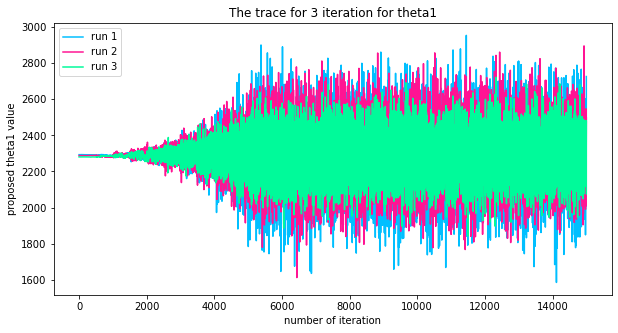

------------------------------------------------------------------------------------------------------------------------


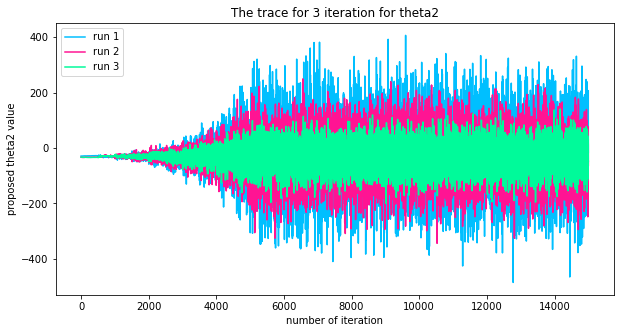

------------------------------------------------------------------------------------------------------------------------


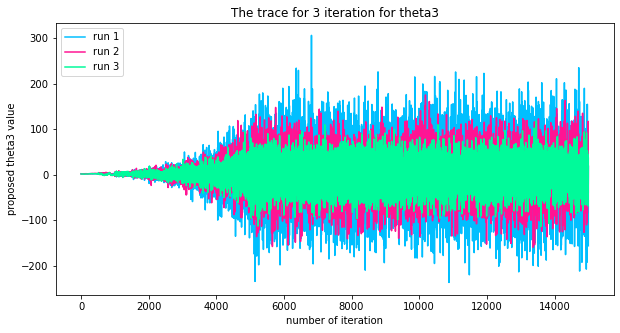

------------------------------------------------------------------------------------------------------------------------


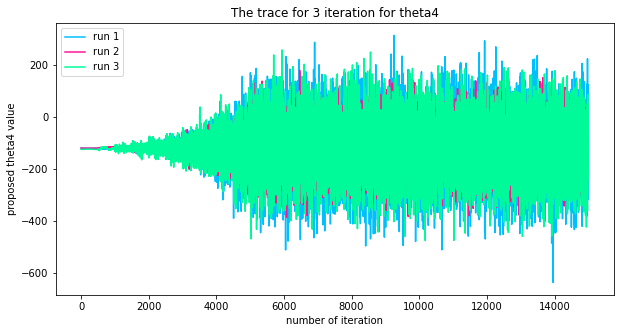

------------------------------------------------------------------------------------------------------------------------


In [31]:
# create a list with the names of the thetas
thetas_names = ['theta1', 'theta2', 'theta3', 'theta4']
# apply the plots for each theta
for theta in thetas_names:
    trace_plot(df_3_different_thetas, theta)
    print ('------------------------------------------------------------------------------------------------------------------------')

9.3: posterior distribution of the parameters 

In [32]:
# the function plot the density(postreior distribution) for each parameter
def density_for_thetas(df_all_chains, num_of_chain):
    # get the relevant data by the number of chain
    data_by_chain = df_all_chains[num_of_chain][['theta1', 'theta2', 'theta3', 'theta4']]
    # plot the density for all the thetas
    data_by_chain.plot.density(figsize=(10,5), color = ['deepskyblue','deeppink', 'mediumspringgreen', 'mediumorchid'])
    # add titles
    plt.title('postreior distribution for chain number ' + str(num_of_chain+1))
    plt.show()

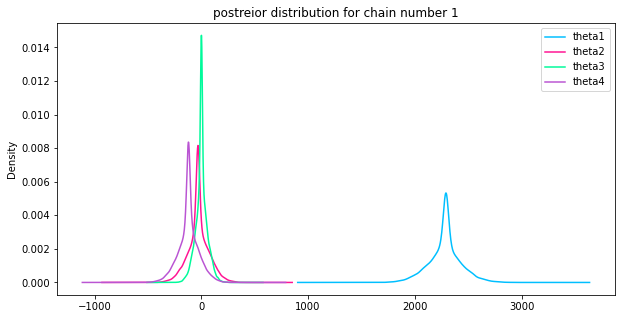

------------------------------------------------------------------------------------------------------------------------


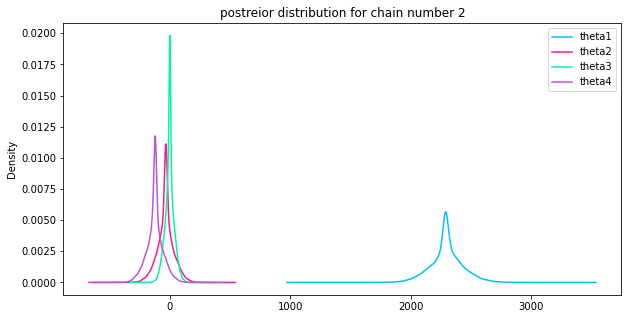

------------------------------------------------------------------------------------------------------------------------


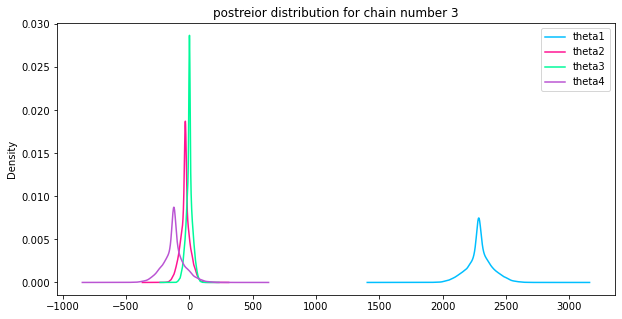

------------------------------------------------------------------------------------------------------------------------


In [33]:
# apply the plots for each run (3 runs)
for i in range(3):
    density_for_thetas(df_3_different_thetas, i)
    print ('------------------------------------------------------------------------------------------------------------------------')

----------------------------
# Part C-  Projection

<b> 10. project 21 upcoming days using MCMC

In [34]:
# get the kernel distribution estimation for the thetas
kde = gaussian_kde(np.array(thetas_current_per_iteration).T)
# sample 100 sets of thetas from the posterior ditrubution I got
thetas = kde.resample(size= 100, seed= 500).T

In [35]:
# the function get set of thetas and data and return the data frame with all the prediction data include the 21 upcoming days
# with these thetas and the likelihood for the first 60 days (where we know the correct cases)
def create_df_prediction(curr_thetas, data):
    # sample value for the epsilon for 21 days from nurmal distribution
    epsilon = np.random.normal(loc= 0, scale= 50, size= 21)   
    # get the df of the prediction for the first 60 days with these thetas
    df = the_model(curr_thetas[0], curr_thetas[1], curr_thetas[2], curr_thetas[3], data)
    # merge the prediction with the correct data for the first 60 days
    df = df.merge(data)
    # calculate the likelihood for this set of thetas
    #likelihood = MSE(curr_thetas, df)
    likelihood = loglikelihood(curr_thetas, df, 500)
    # save the last day (with time 60)
    last_day = previous_day = list(df[df['t']==60]['day'])[0]
    # for each day in the 21 days upcoming
    for i in range(21):
        # define the time
        time = 60+(i+1)
        # daily cases is none because we are not allowed to use them
        daily_cases = None
        # save the last day and update to the next day
        previous_day = last_day
        if (previous_day + 1) <= 6:
            day = previous_day + 1
        # if the last_day +1 is 7 so convert it to 0
        else:
            day = 0
        last_day = day
        # if the days between 61 to 67 so we can use the past data for the number of cases begore 7 days
        if (time-7) <= 60:
            num_cases_last_week = df.iloc[time-7-1]['daily_num_new_cases']
        # else use the prediction as the number of cases before 7 days
        else:
            num_cases_last_week = df.iloc[time-7-1]['predict']
        # make prediction with the data and if it's negative convert to 0 because number of cases is non negative
        predict_data = max(0, curr_thetas[0] + curr_thetas[1]*time + curr_thetas[2]*num_cases_last_week + curr_thetas[3]*day+epsilon[i])
        # get the len of df and create new raw with a list
        df_length = len(df)
        new_row = [time, predict_data, None, day, num_cases_last_week]
        # add the new row to the df
        df.loc[df_length] = new_row
    return df, likelihood

In [36]:
# initialize a list which save all the prediction for the 100 runs
all_predictions_data = []
# initialize maximum likelihood to be lowest
max_log_likelihood = -np.inf
# initialize the best predict by maximum likelihood ans the index for that predict
predict_data_max_likelihood = None
index_max_likelihood = None
# foe each set of thetas
for set_thetas in thetas:
    # apply the create_df_prediction function and get df of prediction and likelihood
    df_prediction, likelihood = create_df_prediction(set_thetas, data_for_model)
    # append the current prediction to the list
    all_predictions_data.append(list(df_prediction['predict']))
    # if the likelihood is better than the best likelihood until now
    if likelihood > max_log_likelihood:
        # save the maximum likelihood, the predicted data with the mwximum likelihood and the index of the maximum likelihood
        max_log_likelihood = likelihood
        predict_data_max_likelihood = list(df_prediction['predict'])
        index_max_likelihood = len(all_predictions_data)-1

<b> 11. plot results

In [37]:
# define the start and end dates for the 60 days
start_date_prediction = '2021-01-16'
end_date_original = '03/17/21'
# convert the end date to date time object and add 21 days to it
date_1 = datetime.datetime.strptime(end_date_original, "%m/%d/%y")
end_date_prediction = date_1 + datetime.timedelta(days=21)
# convert back the date time object to string
end_date_prediction = str(end_date_prediction)[:11]
# get only the data with dates between the start and end dates+21 days
data_new_cases_for_81_days = data_new_cases.loc[(data_new_cases['daily_date'] >= start_date) & (data_new_cases['daily_date'] < end_date)]['daily_num_new_cases']

In [38]:
def plot_prediction(all_predictions_data, data_new_cases_for_81_days, limit=False):
    # for each prediction if it is not the prediction with the best likelihood plot it in grey
    for i in range(len(all_predictions_data)):
        if i != index_max_likelihood:
            plt.plot(range(len(all_predictions_data[0])), all_predictions_data[i],c= 'lightgrey')
    # plot the best prediction with the largest likelihood in black
    plt.plot(range(len(all_predictions_data[0])), predict_data_max_likelihood,c= 'black', lw=2.5, label= 'Model MLE')
    # plot the actual number of daily cases in red dots
    plt.plot(range(data_new_cases_for_81_days.shape[0]), data_new_cases_for_81_days, c='red', marker='o', markersize= 1.5, ls=" ", label='data')
    # add titles
    plt.xlabel('time')
    plt.ylabel('number of daily new cases')
    plt.title('Prediction for 21 upcoming days over 100 differents thetas')
    # if want to limit the y axis
    if limit:
        plt.ylim(0,15000)
    # add seperate line for the prediction and the 60 days
    plt.axvline(x=60, label='seperate for prediction', lw=2)
    # add legend
    plt.legend()
    plt.show()

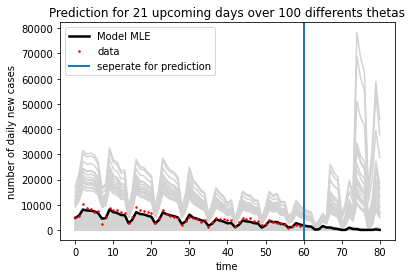

In [39]:
plot_prediction(all_predictions_data, data_new_cases_for_81_days)

The same plot but with  limit in y axis to see better the predictions

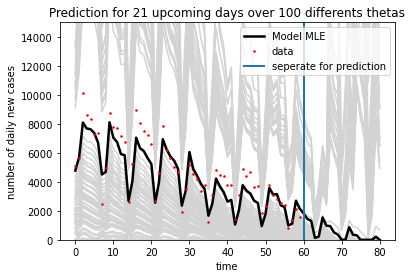

In [40]:
plot_prediction(all_predictions_data, data_new_cases_for_81_days, limit=True)